# Predicting Facial Points - Kaggle
The following code is for the kaggle competition linked [here](https://www.kaggle.com/c/facial-keypoints-detection).

## Data files

1. training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
2. test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels

In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Dense, Activation, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


### Helper Functions to Load Files

In [2]:
def load(test=False, cols=None):
    
    fname = "test.csv" if test else "training.csv"
    df = pd.read_csv(fname)
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols)+['Image']]
    
    #print( df.count())
    df = df.dropna()
    columns = df.columns
    
    X = np.vstack(df['Image'].values)#/255
    X = X.astype(np.float32)
    
    if not test:
        y = df[df.columns[:-1]].values
        #y = (y-48)/48
        X, y = shuffle(X, y, random_state=20)
        y = y.astype(np.float32)
    else:
        y = None
        columns = None
    
    return X, y, columns

def load2d(test=False, cols=None):
    
    X, y, columns = load(test, cols)
    X = X.reshape(-1,96,96, 1)
    
    return X, y, columns

## Load Training Data

In [3]:
X, y, columns = load2d(test=False)
columns = np.array(list(columns[:-1]))
columns

array(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y',
       'mouth_right_corner_x', 'mouth_right_corner_y',
       'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype='<U25')

## Visualizing Some Data Points

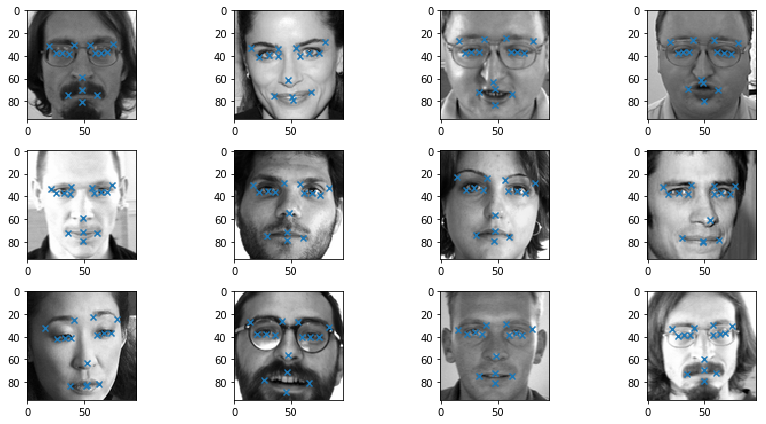

In [4]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(X[i, :, :, 0], cmap="gray")
    plt.scatter(y[i, range(0, 30, 2)], y[i, range(1, 30, 2)], marker='x')

plt.tight_layout()
plt.show()

## Extract Test data

In [5]:
X_test, _, __ = load2d(test=True)
X_test.shape

(1783, 96, 96, 1)

## Convolutional Neural Network

In [6]:
model = Sequential()

model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Conv2D(24, 5, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(96, 96, 1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(36, 5))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(48, 5))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(64, 3))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

model.add(Dense(90))
model.add(Activation("relu"))

model.add(Dense(30))
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 24)        624       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 36)        21636     
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 36)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 36)        0         
__________

## Training Time

In [8]:
# save best weights
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)

# num epochs
epochs = 400

# run model
hist = model.fit(X, y, epochs=epochs, 
                 validation_split=0.2, callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)

Train on 1712 samples, validate on 428 samples
Epoch 1/400
Epoch 00000: val_loss improved from inf to 241.41758, saving model to face_model.h5
8s - loss: 116.5461 - acc: 0.7044 - val_loss: 241.4176 - val_acc: 0.7079
Epoch 2/400
Epoch 00001: val_loss improved from 241.41758 to 146.87348, saving model to face_model.h5
8s - loss: 116.4440 - acc: 0.7050 - val_loss: 146.8735 - val_acc: 0.7079
Epoch 3/400
Epoch 00002: val_loss improved from 146.87348 to 61.29219, saving model to face_model.h5
8s - loss: 102.8731 - acc: 0.7044 - val_loss: 61.2922 - val_acc: 0.7079
Epoch 4/400
Epoch 00003: val_loss did not improve
8s - loss: 102.9453 - acc: 0.7044 - val_loss: 64.3043 - val_acc: 0.7079
Epoch 5/400
Epoch 00004: val_loss did not improve
8s - loss: 89.2840 - acc: 0.7044 - val_loss: 62.9929 - val_acc: 0.7079
Epoch 6/400
Epoch 00005: val_loss did not improve
8s - loss: 87.8657 - acc: 0.7044 - val_loss: 145.2148 - val_acc: 0.7079
Epoch 7/400
Epoch 00006: val_loss did not improve
8s - loss: 79.4612 - 

## Prediction Time

In [9]:
model.load_weights("face_model.h5")
y_test = model.predict(X_test)
print(y_test.shape)

(1783, 30)


## Processing Data to Meet Submission Format

In [10]:
id_lookup_frame = pd.read_csv("IdLookupTable.csv")
val_reqrd = id_lookup_frame[["ImageId", "FeatureName"]]
val_reqrd.head()

,ImageId,FeatureName
0,1,left_eye_center_x
1,1,left_eye_center_y
2,1,right_eye_center_x
3,1,right_eye_center_y
4,1,left_eye_inner_corner_x


In [11]:
y_res = []
j = 0
k = 0
m = 0
for i in range(1, 1784):
    img = np.array(val_reqrd[val_reqrd["ImageId"]==i])
    if img.shape[0] == 30:
        y_res += list(y_test[i-1,:])
        j += 30
    else:
        slice_img = y_test[i-1, :]
        y_res += [slice_img[j] for j in range(30) if columns[j] in img[:, 1]]
        k += len([slice_img[j] for j in range(30) if columns[j] in img[:, 1]])
y_res = np.array(y_res)
y_res.shape

(27124,)

In [12]:
result_dict = {
    "RowId": range(1,27125),
    "Location": y_res%96
}
result_df = pd.DataFrame(result_dict, )
result_df.to_csv("result.csv", index=False, columns=["RowId", "Location"])